In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from my_modules import risk
from my_modules import data
from my_modules import portfolio
from my_modules import index

from scipy.optimize import minimize
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ind_return = data.get_ind30_vw_returns()
ind_nfirms = data.get_ind30_nfirms()
ind_size = data.get_ind30_size()

In [11]:
total_market_index = index.total_market_index(ind_size, ind_nfirms, ind_return)

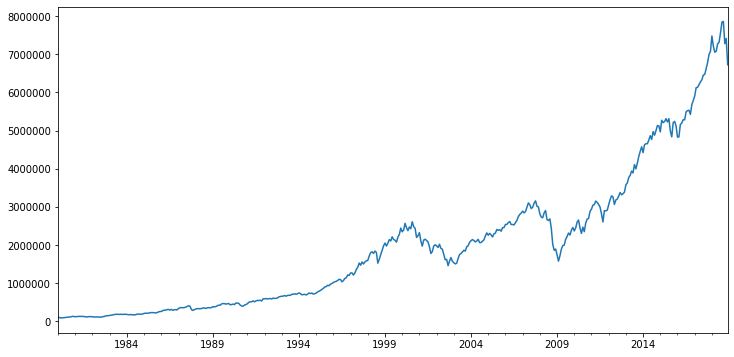

In [12]:
# Comparing with the final figure in 301
total_market_index['1980':].plot(figsize=(12,6))

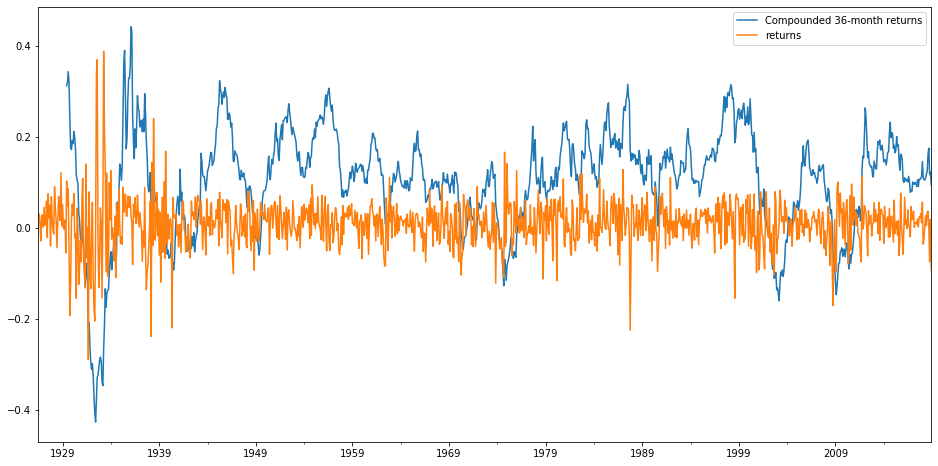

In [16]:
# We calculated the mean for the rolling 36 months before, but we want to compound the returns for the total market
# Aggregate applies the function to each 36 month window
total_market_returns = index.total_market_return(ind_size, ind_nfirms, ind_return)
tmi_trailing36_returns = total_market_returns.rolling(window=36).aggregate(risk.annualise_rets)
tmi_trailing36_returns.plot(figsize=(16,8), label='Compounded 36-month returns', legend=True)
total_market_returns.plot(label='returns', legend='True')
# The rolling returns are as expected less busy than the monthly returns

_We want to find out if there is any relationship between stocks in up and down market regimes_
* **We can examine this by looking at rolling correlation**
    * Using multiindex and .groupby

In [17]:
# ts = time series
ts_corr = ind_return.rolling(window=36).corr()
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
2018-12 Whlsl  0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail  0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals  0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin    0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other  0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                  Clths      Hlth     Chems     Txtls  ...     Telcm  \
2018-12 Whlsl  0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail  0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals  0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin    0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other  0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                  Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
2018-12 Whlsl  0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail  0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals  0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin    0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other  0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                  Meals       Fin     Other  
2018-12 Whlsl  0.643879  0.746480  0.767652  
        Rtail  0.616947  0.611883  0.619918  
        Meals  1.000000  0.502563  0.605226  
        Fin    0.502563  1.000000  0.734837  
        Other  0.605226  0.734837  1.000000  

[5 rows x 30 columns]

In [19]:
ts_corr.index.names = ['date', 'industry'] #Previous Frozenlist([None, None])
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

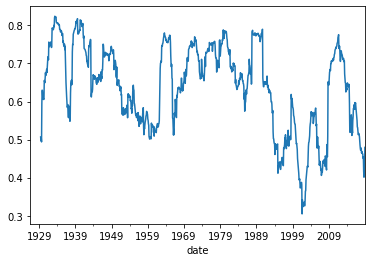

In [21]:
# The level for grouping by we want to use is the date
# The data frame returned by groupby then has the lambda function applied to it
tmi_trailing36_corr = ts_corr.groupby(level='date').apply(lambda corr_matrix: corr_matrix.values.mean())
tmi_trailing36_corr.plot()

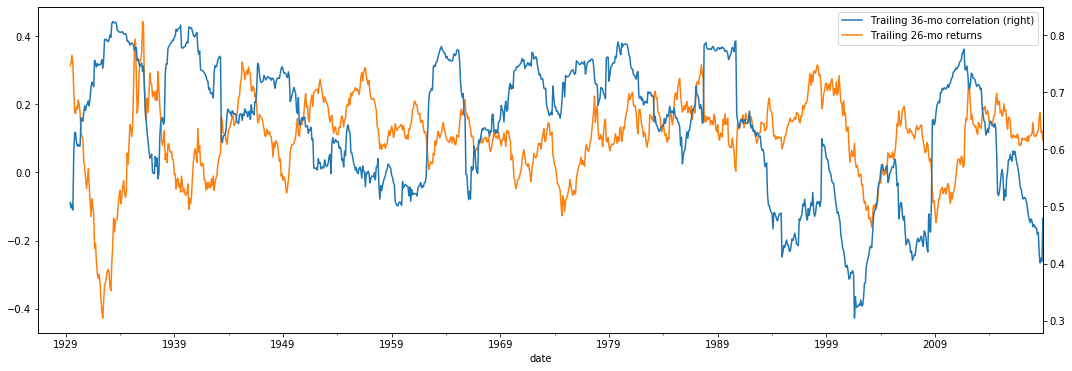

In [23]:
tmi_trailing36_corr.plot(label='Trailing 36-mo correlation', legend=True, secondary_y=True, figsize=(18,6))
tmi_trailing36_returns.plot(label='Trailing 36-mo returns', legend=True)

>When there are market downturns then correlation spikes.

_Getting a number to the relationship we can do:_

In [24]:
tmi_trailing36_returns.corr(tmi_trailing36_corr)

-0.28010065062884126